In [2]:
%run ../modules.ipynb
sys.path.append('../0. kernel-tutorials/')
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
plt.style.use("fivethirtyeight")
cmaps = get_cmaps()
# plt.style.use("../0. kernel-tutorials/utilities/kernel_pcovr.mplstyle")

dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])


In [2]:
#dataset load
len_dataset=79855
load_profile('egazzarrini')
qb = QueryBuilder()
qb.append(orm.StructureData)

In [3]:
!verdi group list

Info: to show groups of all types, use the `-a/--all` option.
  PK  Label               Type string    User
----  ------------------  -------------  ------------------------
   1  structures/raw_cif  core           elena.gazzarrini@epfl.ch
   3  structures/unique   core           elena.gazzarrini@epfl.ch


In [4]:
select=3000
qb_red=random.sample(qb.all(), select)
len(qb_red)

3000

In [5]:
"""description of nearest neighbor calculation here
https://github.com/materialsproject/pymatgen/blob/v2022.0.8/pymatgen/analysis/local_env.py#L3755-L4083"""

gr=['Alkali metals', 'Alkaline earth metals', 'Transition metals', 'Icosagens', 
             'Crystallogens', 'Pnictogens', 'Chalcogens', 'Halogens', 'Nobles gases']

frames_ase=[]

all_groups=[]
n_species=np.zeros(len(qb_red))
packing=np.zeros(len(qb_red))
# avg_coord=np.zeros(len(qb_red))
magic=np.zeros((len(qb_red)))
natoms=np.zeros((len(qb_red)))

nn_avg=np.zeros(len(qb_red))

nn_geo_avg=np.zeros(len(qb_red))

alpha=np.zeros(len(qb_red))
x=np.zeros(len(qb_red))

std_ratio=np.zeros(len(qb_red))

for [structure_data], j in zip(qb_red, range(len(qb_red))):
    
    frame=structure_data.get_ase()
    frame.wrap(eps=1e-10)
 
    frames_ase.append(frame)
    frame_py=structure_data.get_pymatgen()
    natom=len(structure_data.get_site_kindnames())
    
    if natom%4==0:
        magic[j]=1
    else:
        magic[j]=0
    natoms[j]=int(natom)
    
    v=frame.get_volume()  #unit = A^^3
    elements=frame.get_chemical_symbols()
   
    nn=np.zeros((len(elements)))
    nn_geo=np.zeros((len(elements))) 
    elements = np.array(elements)
    n_species[j]=(len(np.unique(elements)))
    V=0
    groups=np.zeros(len(gr))
    rad=np.zeros((natom))
    
    for el,i in zip(elements, range(len(elements))):
#         print(el)
        try:
            nn_geo[i]=CrystalNN(weighted_cn=False, distance_cutoffs=None, 
                        x_diff_weight=0.0,porous_adjustment=False).get_cn(frame_py, i)
        except:
            print('error in neighborlist for CN of structure'+str(frame.get_chemical_formula()))
            pass
        
        el_str=element(str(el))
        #empirical radius 
        r=el_str.atomic_radius
        
        #calculated radius, since the empirical one does not exist (??)
        if el=='Xe':
            r=float(108)
        if el == 'Kr':
            r=float(88)
        if el == 'Rn':
            r=float(120)
            
        rad[i]=r
        group_id=el_str.group_id

        group_type=group_conv(group_id)
        for a in range(len(gr)):
            if group_type == gr[a]:
                groups[a]+=1
        
        atom_vol=(4/3)*pi*(r/100)**3   #unit = A^^3
        V+=atom_vol
            
  
    n_s=np.count_nonzero(rad == np.min(rad))
    n_l=np.count_nonzero(np.max(rad))
    alpha[j]=np.min(rad)/np.max(rad)
    x[j]=n_s/(n_s+n_l)
    std_ratio[j]=np.std(rad)
    nn_geo_avg[j]=nn_geo.mean()

    
    packing[j]=V/v
    all_groups.append(groups/natom) 
       

error in neighborlist for CN of structureMg3
error in neighborlist for CN of structureMg3


In [6]:
np.savez("../datasets/3DCD_packing.npz", frames=frames_ase, alpha=alpha, x=x, sigma=std_ratio, 
         std=std_ratio, CN_avg=nn_geo_avg,
    natoms=natoms, packing=packing,n_species=n_species, 
      groups=all_groups, magic=magic)


/home/egazzarrini/miniconda3/envs/aiida/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [3]:
npzfile = np.load("../datasets/3DCD_packing.npz")

In [13]:

# frames_ase=npzfile['frames']
std_ratio=npzfile['sigma'].ravel()
nn_geo_avg=npzfile['CN_avg']
natoms=npzfile['natoms']
n_species=npzfile['n_species']
all_groups=npzfile['groups']
magic=npzfile['magic']
alpha=npzfile['alpha']
x=npzfile['x']
packing=npzfile['packing']
all_groups.shape

(3000, 9)

In [19]:

dict={r'$\alpha$':alpha,r'$x$':x, r'$\sigma_{radii}$':std_ratio,
    r'$CN_{avg}$':nn_geo_avg,
    r'$N_{atoms,cell}$': natoms, r'$PF$':packing,r'$N_{species}$': n_species, 
       'magic':magic} 

df= pd.DataFrame(dict)

m=df.loc[df['magic'] == 1]
nm=df.loc[df['magic'] == 0]

# sizes_m = [len(m.loc[(m[r'$pf$'] >= 0.7)]), 
#          len(m.loc[(m[r'$pf$'] >= 0.5) & (m[r'$pf$'] < 0.7)]), 
#         len(m.loc[(m[r'$pf$'] >= 0.3) & (m[r'$pf$'] < 0.5)]), 
#          len(m.loc[(m[r'$pf$'] < 0.3)])]

# sizes_nm = [len(nm.loc[(nm[r'$pf$'] >= 0.7)]), 
#          len(nm.loc[(nm[r'$pf$'] >= 0.5) & (nm[r'$pf$'] < 0.7)]), 
#             len(nm.loc[(nm[r'$pf$'] >= 0.3) & (nm[r'$pf$'] < 0.5)]),
#          len(nm.loc[(nm[r'$pf$'] < 0.3)])]
ex=[0.05,0,0,0]

# labels = ['pf $\geq$ 0.7', '0.5 $\leq$ pf < 0.7', '0.3 $\leq$ pf < 0.5', 'pf < 0.3']



<AxesSubplot:xlabel='$\\sigma_{radii}$', ylabel='Density'>

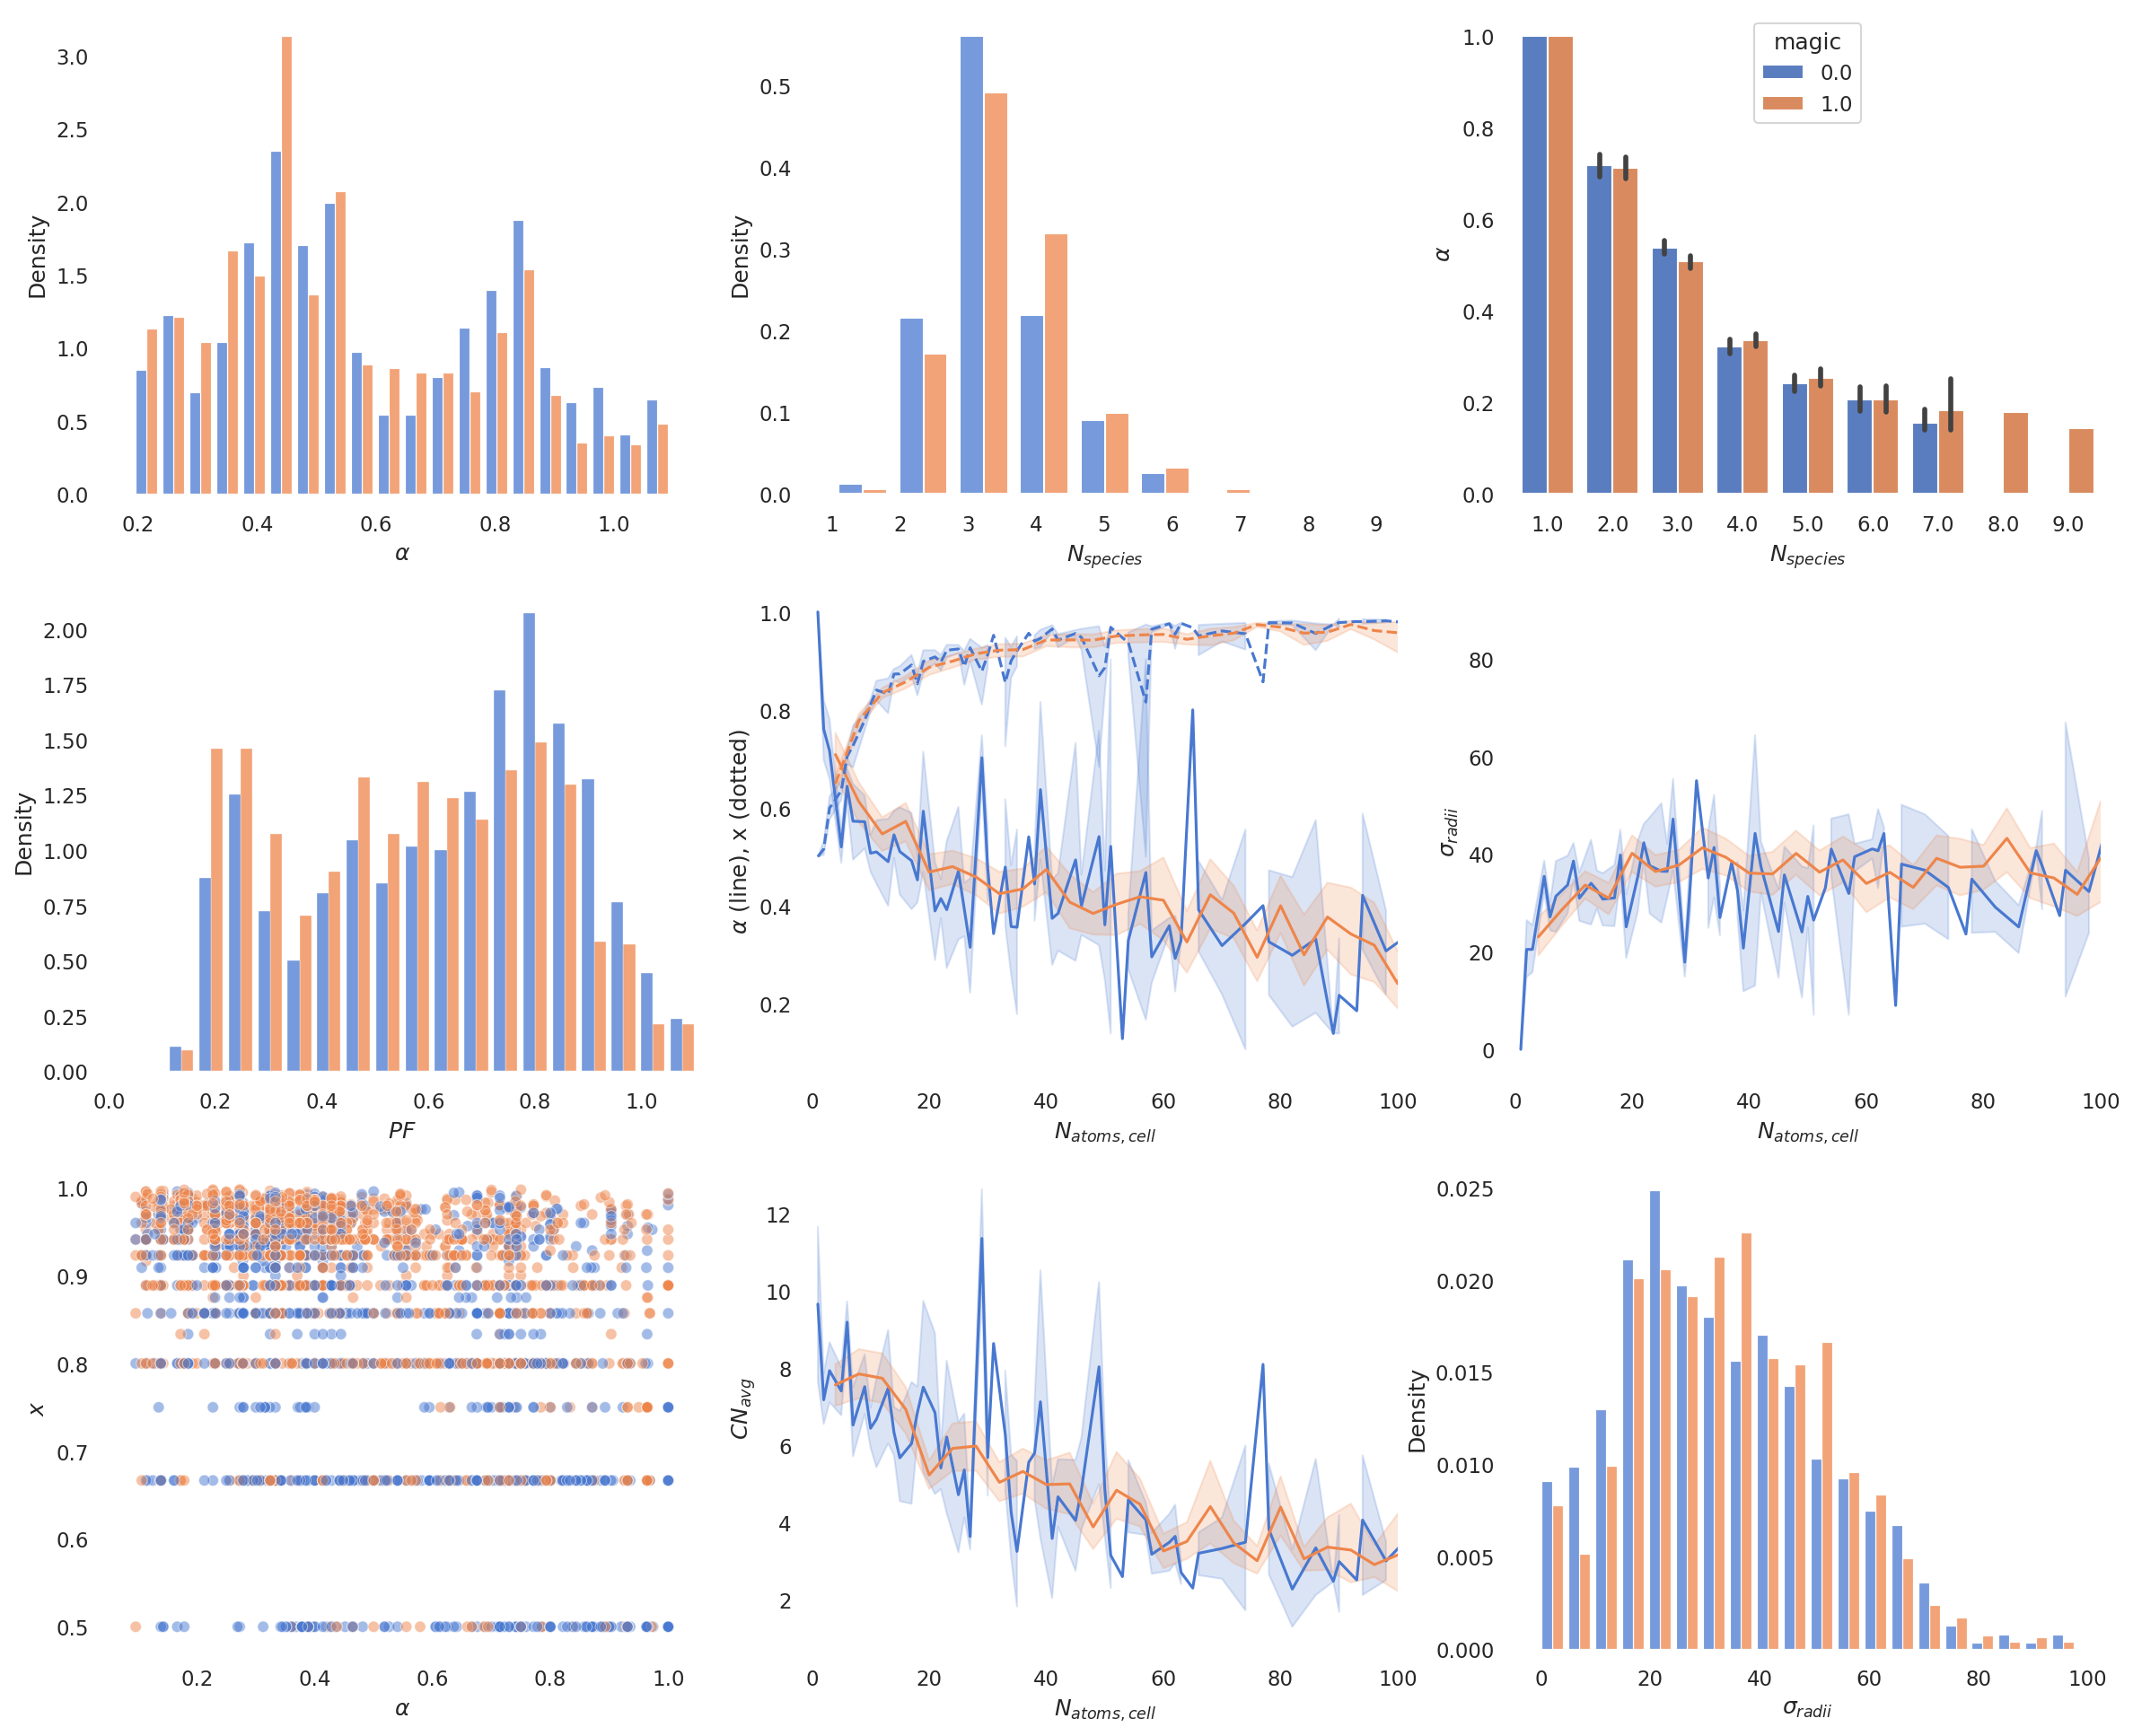

In [25]:
sns.set(style="white", palette="muted", color_codes=True)
fig, axes = plt.subplots(3, 3, figsize=(17, 15))
sns.despine(left=True, bottom=True)

sns.histplot(ax=axes[0][0], data=df, x=r'$\alpha$', hue='magic',stat='density', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=20)
# sns.histplot(ax=axes[0][1], data=df, x=r'$\sigma_{radii}$', hue='magic',stat='density', legend=False,
#                common_norm=False,  multiple='dodge', shrink=.8, bins=20)
sns.histplot(ax=axes[0][1], data=df, x=r'$N_{species}$', hue='magic',stat='density', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=int(max(n_species)))

sns.barplot(ax=axes[0,2], data=df, x=r'$N_{species}$', y=r'$\alpha$', hue='magic')


sns.histplot(ax=axes[1][0], data=df, x=r'$PF$', hue='magic',stat='density', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8)
axes[1,0].set_xlim(0,1.1)
# sns.scatterplot(ax=axes[1][0], data=df, x=r'$\alpha$', y=r'$\sigma_{radii}$', alpha=0.5, hue='magic',legend=False)

sns.lineplot(ax=axes[1,1], data=df, x=r'$N_{atoms,cell}$', y=r'$\alpha$', hue='magic', 
             legend=False)
sns.lineplot(ax=axes[1,1], data=df, x=r'$N_{atoms,cell}$', y=r'$x$', hue='magic', 
             legend=False, linestyle='--')
axes[1,1].set_ylabel(r'$ \alpha$ (line), x (dotted)')
sns.lineplot(ax=axes[1,2], data=df, x=r'$N_{atoms,cell}$', y=r'$\sigma_{radii}$', hue='magic', legend=False)
axes[1,1].set_xlim(0,100)
axes[1,2].set_xlim(0,100)

sns.scatterplot(ax=axes[2,0], data=df, x=r'$\alpha$', y=r'$x$', hue='magic',alpha=0.5, legend=False)
sns.lineplot(ax=axes[2,1], data=df, x=r'$N_{atoms,cell}$', y=r'$CN_{avg}$', hue='magic', legend=False)

axes[2,1].set_xlim(0,100)

sns.histplot(ax=axes[2,2], data=df, x=r'$\sigma_{radii}$', hue='magic',stat='density', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=20)


# m_gr_avg=(df['groups'].loc[df['magic'] == 1]).mean(axis=0)
# nm_gr_avg=(df['groups'].loc[df['magic'] == 0]).mean(axis=0)
# axes[2,2].bar(gr, m_gr_avg, alpha=0.7)
# axes[2,2].bar(gr, nm_gr_avg, alpha=0.7)
# plt.xticks(rotation=90)

(0.0, 1.0)

<Figure size 900x750 with 0 Axes>

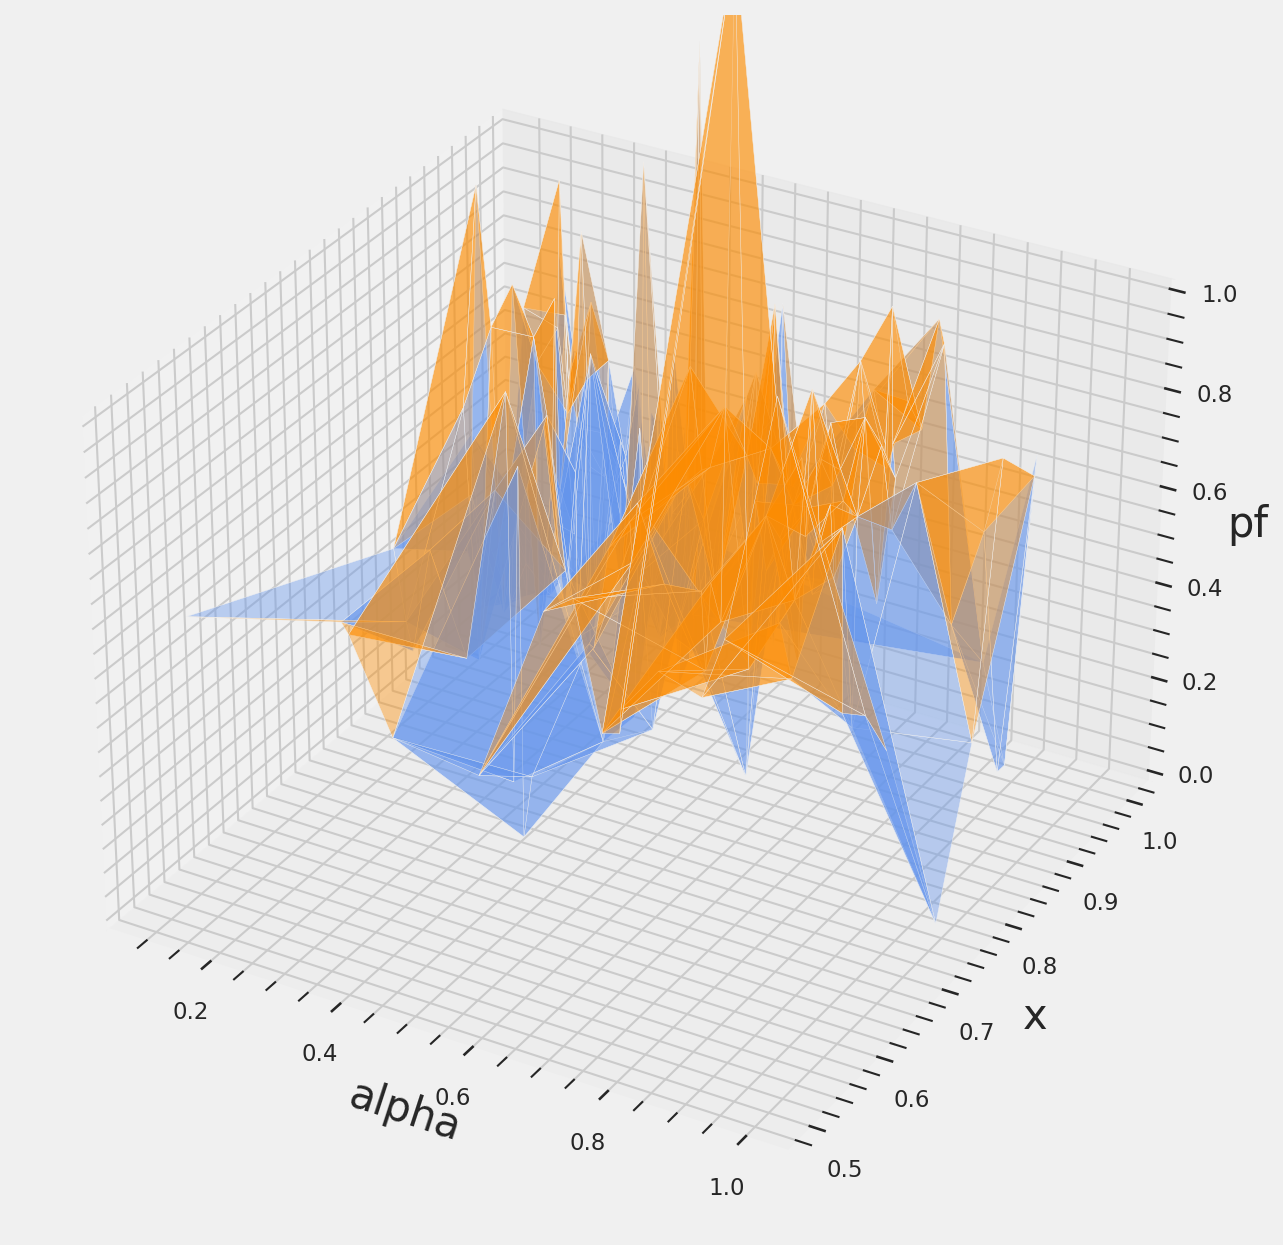

In [13]:
plt.style.use("fivethirtyeight")
sns.despine(left=True, bottom=True)
ax = plt.figure(figsize=(12,10)).add_subplot(projection='3d')

ax.plot_trisurf(alpha[::10], x[::10], packing[::10],alpha=0.4, 
                cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), 
               linewidth=0.2, antialiased=True)

# ax.scatter(alpha[::10], x[::10], packing[::10],alpha=0.4, 
#                 cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), 
#                linewidth=0.2, antialiased=True)

ax.set_xlabel("alpha", size=20)
ax.set_ylabel("x", size=20)
ax.set_zlabel("pf", size=20)
ax.set_zlim(0,1)

In [ ]:
# """description of nearest neighbor calculation here
# https://github.com/materialsproject/pymatgen/blob/v2022.0.8/pymatgen/analysis/local_env.py#L3755-L4083"""

# gr=['Alkali metals', 'Alkaline earth metals', 'Transition metals', 'Icosagens', 
#              'Crystallogens', 'Pnictogens', 'Chalcogens', 'Halogens', 'Nobles gases']

# frames_ase=[]

# all_groups=[]
# n_species=np.zeros(len(qb_red))
# packing=np.zeros(len(qb_red))
# # avg_coord=np.zeros(len(qb_red))
# magic=np.zeros((len(qb_red)))
# natoms=np.zeros((len(qb_red)))

# nn_avg=np.zeros(len(qb_red))

# nn_geo_avg=np.zeros(len(qb_red))

# iso_q=np.zeros(len(qb_red))

# for [structure_data], j in zip(qb_red, range(len(qb_red))):
#     frame=structure_data.get_ase()
#     frame.wrap(eps=1e-10)
    
# #     try:
# #         pos=frame.get_positions()
# #         vor=Voronoi(pos)
# #     except:
# #         continue
        
#     frames_ase.append(frame)
#     frame_py=structure_data.get_pymatgen()
#     natom=len(structure_data.get_site_kindnames())
    
#     if natom%4==0:
#         magic[j]=1
#     else:
#         magic[j]=0
#     natoms[j]=int(natom)
    
#     v=frame.get_volume()  #unit = A^^3
#     elements=structure_data.get_site_kindnames()
    
#     nn=np.zeros((len(elements)))  
    
#     nn_geo=np.zeros((len(elements))) 
    
# #     vor=Voronoi(pos)  
# #     polygons = {}
    
# #     for id, region_index in enumerate(vor.point_region):
# #         points = []
# #         for vertex_index in vor.regions[region_index]:
# #             if vertex_index != -1:  # the library uses this for infinity
# #                 points.append(list(vor.vertices[vertex_index]))
# #         points.append(points[0])    
# #         polygons[id]=points 
# #     a_tot = sum(poly_area(polygons[i]) for i in range(len(polygons)))
# #     iso=36*pi*v**2/(a_tot**3)
# #     iso_q[j]=iso

#     elements = np.array(elements)
#     n_species[j]=(len(np.unique(elements)))
#     V=0
#     groups=np.zeros(len(gr))
#     for el,i in zip(elements, range(len(elements))):
# #         print(el)
#         el_str=element(str(el))
#         #empirical radius 
#         r=el_str.atomic_radius
#         #calculated radius, since the empirical one does not exist (??)
#         if el=='Xe':
#             r=float(108)
#         if el == 'Kr':
#             r=float(88)
#         if el == 'Rn':
#             r=float(120)
# #         print(r)
#         group_id=el_str.group_id

#         group_type=group_conv(group_id)
#         for a in range(len(gr)):
#             if group_type == gr[a]:
#                 groups[a]+=1
        
#         atom_vol=(4/3)*pi*(r/100)**3   #unit = A^^3
#         V+=atom_vol
# #         nn[i]=CrystalNN(weighted_cn=False, distance_cutoffs=None,x_diff_weight=3.0,
# #                          porous_adjustment=True).get_cn(frame_py, i)
        
#         nn_geo[i]=CrystalNN(weighted_cn=False, distance_cutoffs=None, 
#                         x_diff_weight=0.0, 
#                          porous_adjustment=False).get_cn(frame_py, i)
        
# #     avg_coord[j]=nn.mean()
# #     nn_avg[j]=nn.mean()
 
#     nn_geo_avg[j]=nn_geo.mean()

    
#     packing[j]=V/v
#     all_groups.append(groups/natom) 
    

In [ ]:
len(magic),len(natoms), len(packing), len(iso_q), len(n_species), len(all_groups), len(nn_geo_avg)

In [ ]:
# len(iso_q), len(frames_ase)
# dict={ 'nn_avg':nn_avg, 
#     'nn_geo_avg':nn_geo_avg,
#     'natoms': natoms, 'packing_fraction':packing,'IQ':iso_q,'n_species': n_species, 
#      'magic':magic} 

# df= pd.DataFrame(dict)
# df=df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]



# dict={
#     'nn_geo_avg':nn_geo_avg,
#     'natoms': natoms, 'packing_fraction':packing,'n_species': n_species, 
#        'magic':magic} 

# df= pd.DataFrame(dict)
# df.head(10)

In [ ]:
# sns.set(style="white", palette="muted", color_codes=True)

# f, ax = plt.subplots(figsize=(9, 8))
# sns.despine(left=True, bottom=True)
# g=sns.histplot(data=df, x='IQ', hue='magic',stat='density', 
#                common_norm=False,  multiple='dodge', shrink=.8, bins=20)
# plt.xticks(c='grey')
# plt.yticks(c='grey')
# plt.ylabel('Count', c='grey')
# plt.xlabel('IQ', c='grey')

# plt.show()
# plt.close()

# plt.style.use("fivethirtyeight")
# f, ax = plt.subplots(figsize=(9,8))
# plt.scatter(iso_q,nn_avg,  c=magic, s=90,
#             cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), alpha=0.6)
# plt.xlabel('IQ', color='dimgrey')
# plt.ylabel('Average Coordination', color='dimgrey')
# plt.xlim(0,1)
# plt.legend()
# plt.show()
# plt.close()

# plt.style.use("fivethirtyeight")
# f, ax = plt.subplots(figsize=(9,8))
# plt.scatter(iso_q, packing, c=magic, s=90, 
#             cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), alpha=0.6)
# plt.xlabel('IQ', color='dimgrey')
# plt.ylabel('Packing Fraction', color='dimgrey')
# plt.xlim(0,1)
# plt.legend()

In [ ]:
plt.style.use("fivethirtyeight")
col=['#1f77b4', '#2ca02c', '#bcbd22','#ff7f0e',  '#d62728', '#9467bd', '#8c564b', '#e377c2','#7f7f7f']

m_gr_avg=(df['groups'].loc[df['magic'] == 1]).mean(axis=0)
nm_gr_avg=(df['groups'].loc[df['magic'] == 0]).mean(axis=0)

ex=[0,0,0.05,0,0,0,0,0,0]
labels=gr
fig, (ax_m, ax_n)=plt.subplots(1,2,figsize=(12,8))
patches, texts, auto =ax_m.pie(m_gr_avg,colors=col, autopct='%1.1f%%', 
                               explode=ex, pctdistance=1.17)
for auto in auto:
    auto.set_color('grey')
    
ax_m.axis('equal')
ax_m.set_title('Magic structures', color='dimgrey')
patches, texts, auto =ax_n.pie(nm_gr_avg, autopct='%1.1f%%', colors=col,
                               explode=ex, pctdistance=1.17)
# for text in texts:
#     text.set_color('grey')
for auto in auto:
    auto.set_color('grey')
ax_n.axis('equal')
ax_n.set_title('Rest of structures', color='dimgrey')
fig.legend(patches, labels,  labelcolor='dimgrey',frameon=False, loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.2))

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True, bottom=True)
# g=sns.lineplot(data=df, x='natoms', y='nn_avg', hue='magic', linestyle='--', legend=False)

i=sns.lineplot(data=df, x='natoms', y='nn_geo_avg', hue='magic', legend=False)

plt.xticks(c='grey')
plt.yticks(c='grey')
plt.ylabel('Average coordination number', c='grey')
plt.xlabel('Number of atoms in unit cell', c='grey')
plt.xlim(0,100)

plt.show()
plt.close()

In [ ]:
plt.style.use("fivethirtyeight")
f, ax = plt.subplots(figsize=(9,8))
# plt.scatter(nn_avg, packing, c=magic, s=90, marker='+', label='chemical',
#             cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), alpha=0.6)
plt.scatter(nn_geo_avg, packing, c=magic, s=90, label= 'structural',
            cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), alpha=0.6)
plt.xlabel('Average Coordination', color='dimgrey')
plt.ylabel('Packing Fraction', color='dimgrey')
plt.ylim(0,1)
# plt.legend()

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)

f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True, bottom=True)
g=sns.histplot(data=df, x='packing_fraction', hue='magic',stat='density', 
               common_norm=False,  multiple='dodge', shrink=.8, bins=40)
plt.xticks(c='grey')
plt.yticks(c='grey')
plt.ylabel('Count', c='grey')
plt.xlabel('Packing fraction (V_atoms/V_cell)', c='grey')
plt.xlim(0,1)
plt.show()
plt.close()


f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True, bottom=True)
g=sns.histplot(data=df, x='n_species', hue='magic',stat='density', 
               common_norm=False, multiple='dodge', shrink=.8, bins=int(max(n_species)))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(c='grey')
plt.yticks(c='grey')
plt.ylabel('Count', c='grey')
plt.xlabel('Number of species', c='grey')
plt.show()
plt.close()

In [ ]:
plt.style.use("fivethirtyeight")
m=df.loc[df['magic'] == 1]
nm=df.loc[df['magic'] == 0]
print(m['packing_fraction'].mean(), nm['packing_fraction'].mean())
ex=[0.05,0,0,0]
# pie chart
labels = ['pf $\geq$ 0.7', '0.5 $\leq$ pf < 0.7', '0.3 $\leq$ pf < 0.5', 'pf < 0.3']

sizes_m = [len(m.loc[(m['packing_fraction'] >= 0.7)]), 
         len(m.loc[(m['packing_fraction'] >= 0.5) & (m['packing_fraction'] < 0.7)]), 
        len(m.loc[(m['packing_fraction'] >= 0.3) & (m['packing_fraction'] < 0.5)]), 
         len(m.loc[(m['packing_fraction'] < 0.3)])]

sizes_nm = [len(nm.loc[(nm['packing_fraction'] >= 0.7)]), 
         len(nm.loc[(nm['packing_fraction'] >= 0.5) & (nm['packing_fraction'] < 0.7)]), 
            len(nm.loc[(nm['packing_fraction'] >= 0.3) & (nm['packing_fraction'] < 0.5)]),
         len(nm.loc[(nm['packing_fraction'] < 0.3)])]

fig, (ax_m, ax_n)=plt.subplots(1,2,figsize=(12,8))
patches, texts, auto =ax_m.pie(sizes_m, autopct='%1.1f%%', 
                               explode=ex, pctdistance=1.18)

for auto in auto:
    auto.set_color('grey')
    
ax_m.axis('equal')
ax_m.set_title('Magic structures', color='dimgrey')
patches, texts, auto =ax_n.pie(sizes_nm, autopct='%1.1f%%', 
                               explode=ex, pctdistance=1.18)
# for text in texts:
#     text.set_color('grey')
for auto in auto:
    auto.set_color('grey')

ax_n.axis('equal')
ax_n.set_title('Rest of structures', color='dimgrey')
fig.legend(patches, labels, labelcolor='dimgrey', frameon=False, loc="lower center", fontsize=15)

In [ ]:
plt.style.use("fivethirtyeight")
m=df.loc[df['magic'] == 1]
nm=df.loc[df['magic'] == 0]
print(m['packing_fraction'].mean(), nm['packing_fraction'].mean())
# ex=[0.05,0,0]
# pie chart
labels = ['FCC or HCP', 'BCC']
# 0.74, 0.68
sizes_m = [len(m.loc[(m['packing_fraction'] > 0.72) & (m['packing_fraction'] < 0.76)]), 
         len(m.loc[(m['packing_fraction'] > 0.66) & (m['packing_fraction'] < 0.70)])]

sizes_nm = [len(nm.loc[(nm['packing_fraction'] > 0.72) & (nm['packing_fraction'] < 0.76)]), 
         len(nm.loc[(nm['packing_fraction'] > 0.66) & (nm['packing_fraction'] < 0.70)])]

fig, (ax_m, ax_n)=plt.subplots(1,2,figsize=(12,8))
patches, texts, auto =ax_m.pie(sizes_m, autopct='%1.1f%%',
                               pctdistance=1.18)

for auto in auto:
    auto.set_color('grey')
    
ax_m.axis('equal')
ax_m.set_title('Magic structures', color='dimgrey')
patches, texts, auto =ax_n.pie(sizes_nm, autopct='%1.1f%%',
                              pctdistance=1.18)
# for text in texts:
#     text.set_color('grey')
for auto in auto:
    auto.set_color('grey')

ax_n.axis('equal')
ax_n.set_title('Rest of structures', color='dimgrey')
fig.legend(patches, labels, labelcolor='dimgrey', frameon=False, loc="lower center", fontsize=15)

In [ ]:
# frames_ase=[]
# iso_q=[]
# natoms=[]


# for [structure_data] in qb_red[::10]:
#     atoms=structure_data.get_ase()
#     atoms.wrap()
#     pos=atoms.get_positions()
#     try:
#         vor=Voronoi(pos)
#     except:
#         continue
#     frames_ase.append(atoms)
#     natom = len(structure_data.get_site_kindnames())
#     natoms.append(natom)
#     vol=atoms.get_volume()
#     vor=Voronoi(pos)  
#     polygons = {}
#     for id, region_index in enumerate(vor.point_region):
#         points = []
#         for vertex_index in vor.regions[region_index]:
#             if vertex_index != -1:  # the library uses this for infinity
#                 points.append(list(vor.vertices[vertex_index]))
#         points.append(points[0])    
#         polygons[id]=points 
#     a_tot = sum(poly_area(polygons[i]) for i in range(len(polygons)))
#     iso=36*pi*vol**2/(a_tot**3)
#     iso_q.append(iso)
# len(iso_q)"""Removing Nan valies and infinity"""
# for l in range(len(lista)) if np.isinf(lista[l])!=True or np.isnan(lista[l])!=True]



# def remove_zeros(lista):
#     idx=[l for l in range(len(lista)) if np.isinf(lista[l])!=True and np.isnan(lista[l])!=True]
#     return idx

# indexes=remove_zeros(iso_q)
# IQ= list(itemgetter(*indexes)(iso_q))
# natoms_red=list(itemgetter(*indexes)(natoms))
# frames_ase=list(itemgetter(*indexes)(frames_ase))